In [3]:
# ! pip install sklearn
# general imports 
import allensdk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

# set data path
import sys
import platform
import os
from os.path import join as pjoin
from pathlib import Path


import sys
sys.path.insert(0, '/code/src')
import importlib
import plot_utils
# reload it after edits
importlib.reload(plot_utils)


<module 'plot_utils' from '/code/src/plot_utils.py'>

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# reload it after edits
import importlib
importlib.reload(plot_utils)
from plot_utils import plot_area_covariances_with_eigs, build_area_packet

In [4]:
platstring = platform.platform()
system = platform.system()
if system == "Darwin":
    # macOS
    data_dir = "/Volumes/Brain2025/"
elif system == "Windows":
    # Windows (replace with the drive letter of USB drive)
    data_dir = "E:/"
elif "amzn" in platstring:
    # then on CodeOcean
    data_dir = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_dir = "/media/$USERNAME/Brain2025/"
data_root = Path(data_dir)
print('data directory set to', data_dir)

data directory set to /data/


In [5]:
# Visual Behavior Neuropixels 
from allensdk.brain_observatory.behavior.behavior_project_cache.\
    behavior_neuropixels_project_cache \
    import VisualBehaviorNeuropixelsProjectCache

cache_dir = '/root/capsule/data/'

cache = VisualBehaviorNeuropixelsProjectCache.from_local_cache(
            cache_dir=cache_dir, use_static_cache=True)

/opt/conda/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
behaviour_session_table = cache.get_behavior_session_table() 
ecephys_session_table = cache.get_ecephys_session_table() 
probe_table = cache.get_probe_table() 
channel_table = cache.get_channel_table() 
unit_table = cache.get_unit_table() 

In [7]:
no_genotype_ecephys_session_table = ecephys_session_table[ecephys_session_table.genotype == "wt/wt"]
# no_genotype_ecephys_session_table.head()

In [8]:
a_novel_session_id = 1044594870
# a_familiar_session_id = 1044385384
a_novel_session = cache.get_ecephys_session(
            ecephys_session_id=a_novel_session_id)
# a_familiar_session = cache.get_ecephys_session(
#             ecephys_session_id=a_familiar_session_id)
a_novel_session.metadata

/opt/conda/lib/python3.9/site-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.6.0-alpha, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)
/opt/conda/lib/python3.9/site-packages/allensdk/brain_observatory/behavior/data_objects/metadata/subject_metadata/full_genotype.py:57: UserWarning: Unable to parse cre_line from full_genotype
  warnings.warn('Unable to parse cre_line from full_genotype')


{'equipment_name': 'NP.1',
 'sex': 'F',
 'age_in_days': 152,
 'stimulus_frame_rate': 60.0,
 'session_type': 'EPHYS_1_images_H_5uL_reward',
 'date_of_acquisition': datetime.datetime(2020, 8, 20, 22, 3, 56, tzinfo=tzutc()),
 'reporter_line': None,
 'cre_line': None,
 'behavior_session_uuid': UUID('3338aa28-9865-443b-a69a-83f78f6dba19'),
 'driver_line': [],
 'mouse_id': '524761',
 'project_code': 'Not Available',
 'full_genotype': 'wt/wt',
 'behavior_session_id': 1044624428,
 'ecephys_session_id': 1044594870}

In [9]:
units = a_novel_session.get_units()
channels = a_novel_session.get_channels()

unit_channels = units.merge(channels, left_on='peak_channel_id', right_index=True)

In [14]:
#first let's sort our units by depth
unit_channels = unit_channels.sort_values('probe_vertical_position', ascending=False)

#now we'll filter them
good_unit_filter = ((unit_channels['snr']>1)&
                    (unit_channels['isi_violations']<1)&
                    (unit_channels['firing_rate']>0.1))

good_units = unit_channels.loc[good_unit_filter]
spike_times = a_novel_session.spike_times
stimulus_presentations = a_novel_session.stimulus_presentations
change_times = stimulus_presentations[stimulus_presentations['active']&
                            stimulus_presentations['is_change']]['start_time'].values
stimulus_presentations

,stimulus_block,image_name,duration,start_time,end_time,start_frame,end_frame,is_change,is_image_novel,omitted,...,stimulus_index,active,rewarded,color,temporal_frequency,position_y,orientation,spatial_frequency,contrast,position_x
stimulus_presentations_id,,,,,,,,,,,,,,,,,,,,,
0,0,im104_r,0.250213,26.415843,26.666057,60,75,False,True,False,...,-99,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,im104_r,0.250213,27.166484,27.416697,105,120,False,True,False,...,-99,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,im104_r,0.250199,27.917095,28.167294,150,165,False,True,False,...,-99,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,im104_r,0.250216,28.667709,28.917925,195,210,False,True,False,...,-99,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,im104_r,0.250199,29.418357,29.668556,240,255,False,True,False,...,-99,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13396,5,im024_r,0.250211,8784.826648,8785.076859,523377,523392,False,True,False,...,-99,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13397,5,im024_r,0.250207,8785.577281,8785.827488,523422,523437,False,True,False,...,-99,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13398,5,im024_r,0.250206,8786.327901,8786.578107,523467,523482,False,True,False,...,-99,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
areas_to_plot = ['DG', 'CA1', 'CA3', 'VISl','VISp','VISpm', 'VISal', 'VISrl']
area_packets = [build_area_packet(a, good_units, spike_times, sort_key='depth') 
                for a in areas_to_plot]

area_packet = area_packets[1]


/opt/conda/lib/python3.9/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/conda/lib/python3.9/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


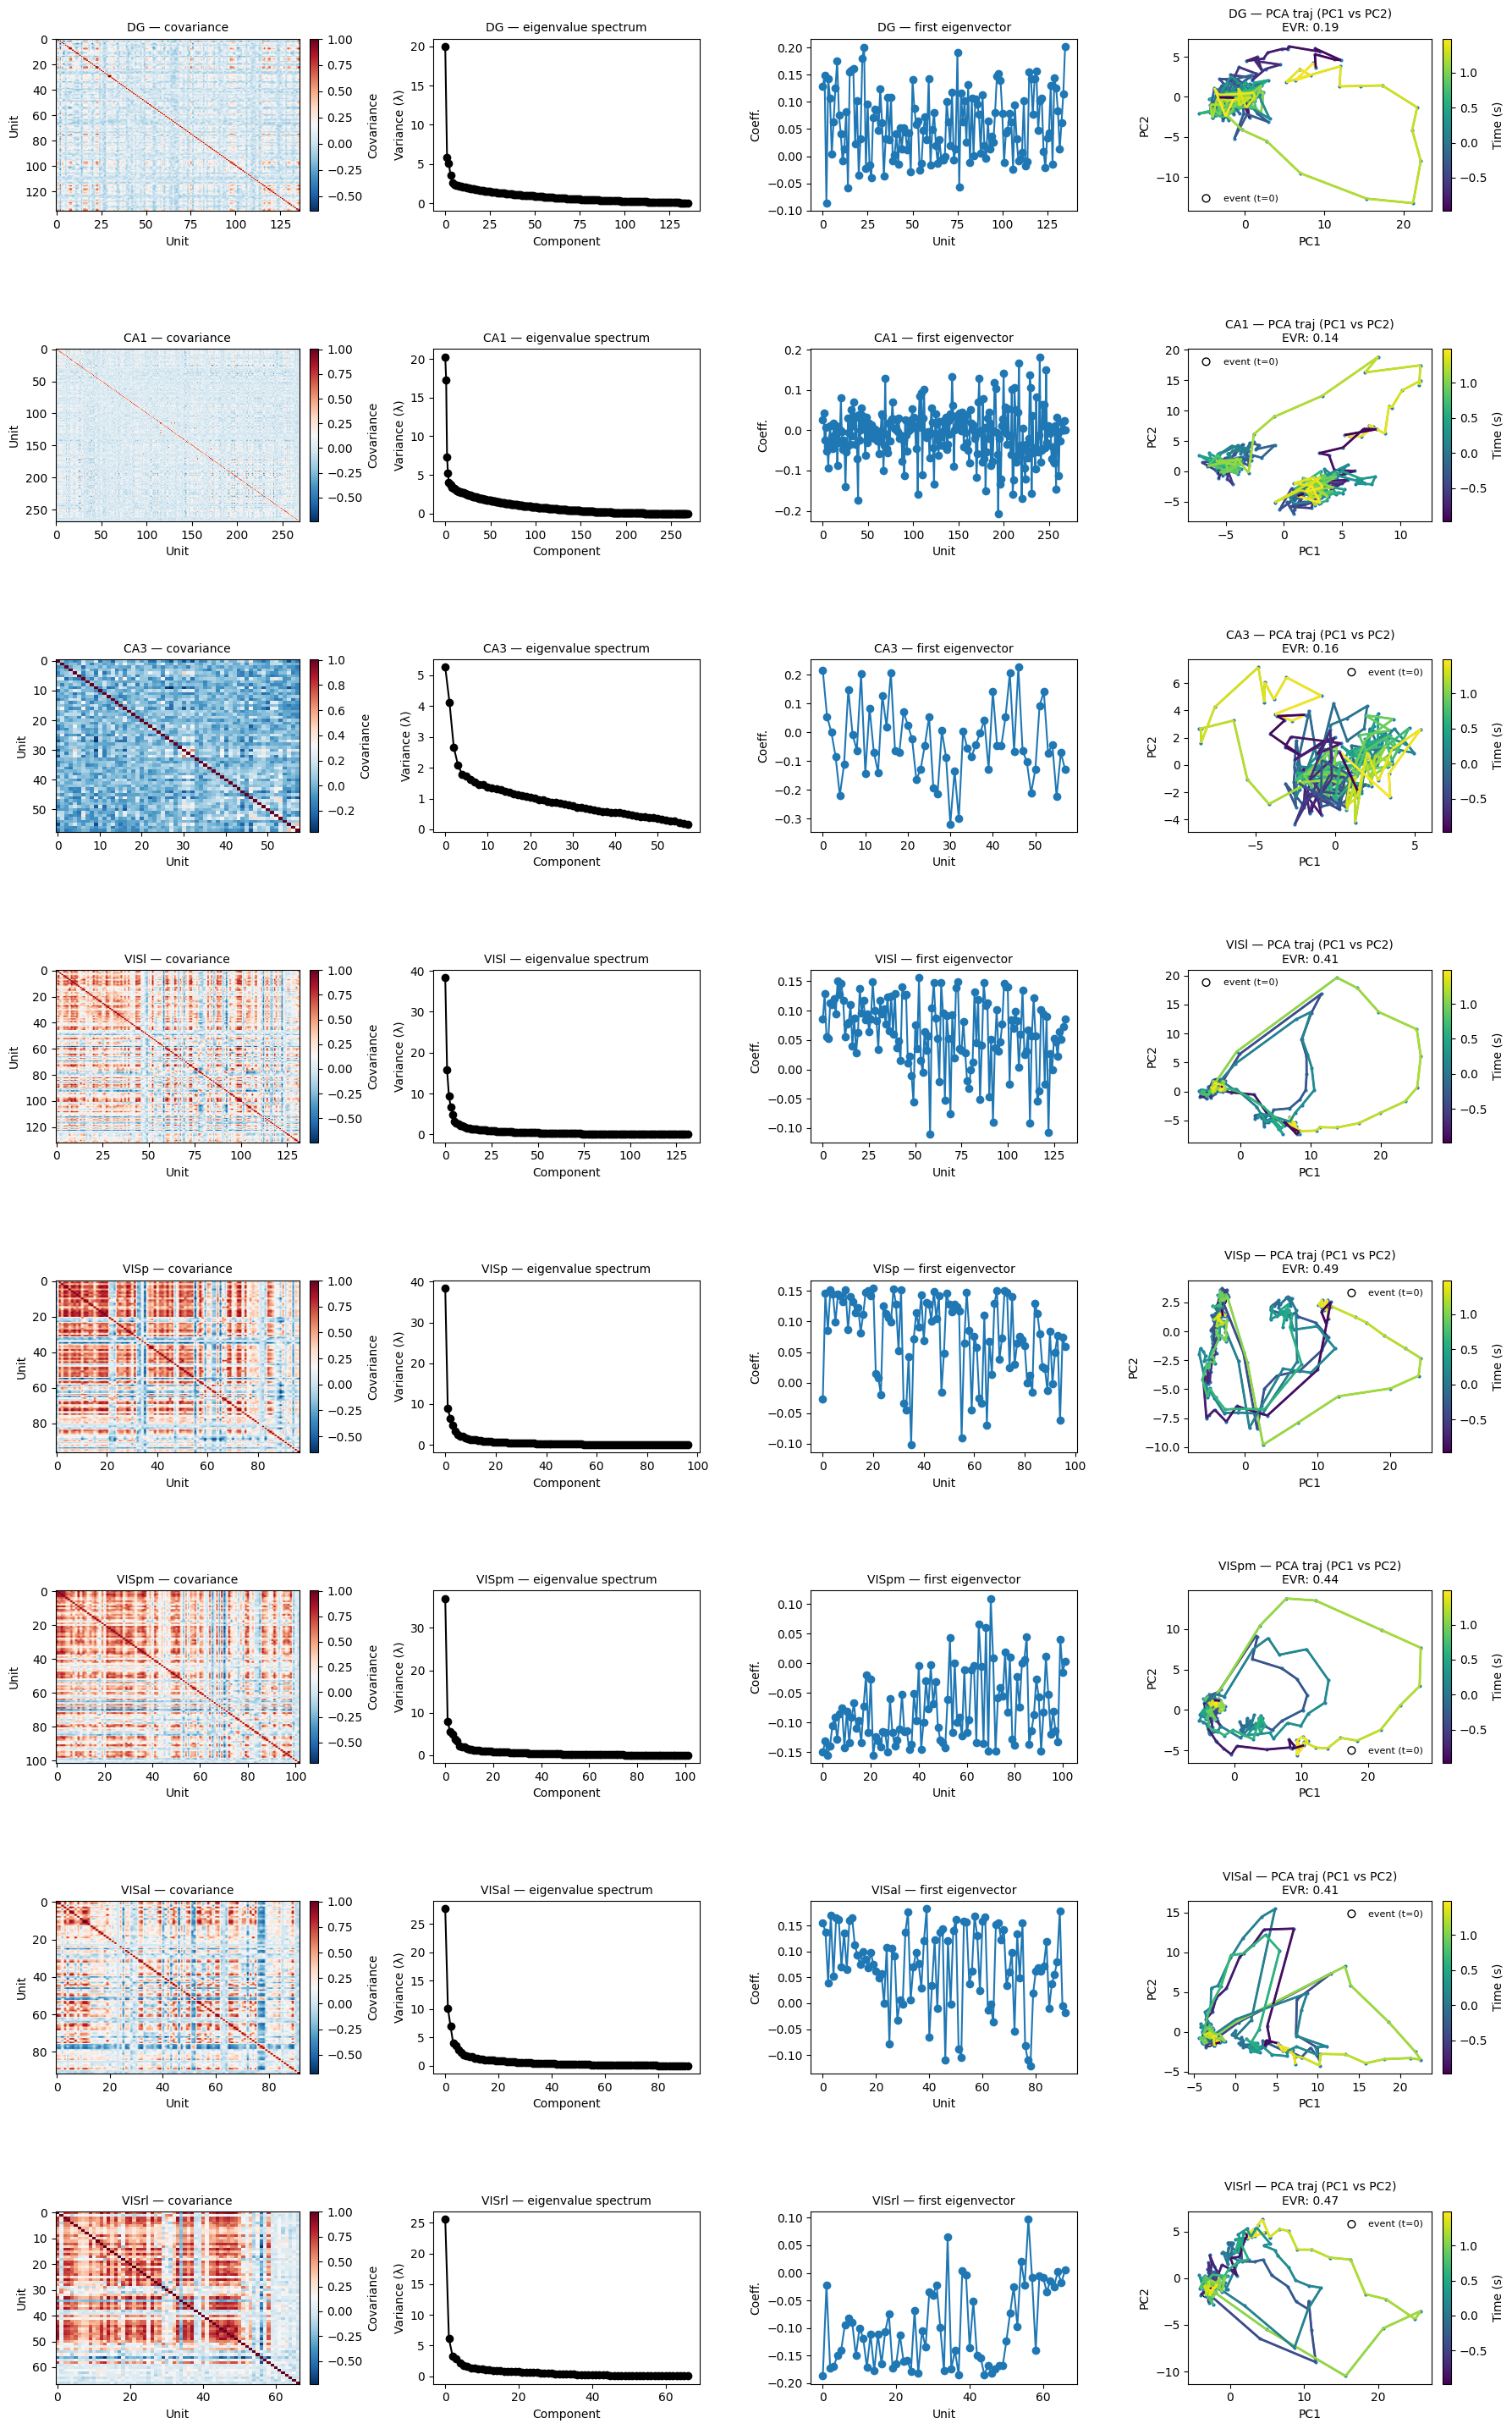

In [45]:
_, _, cov_results = plot_area_covariances_with_eigs(area_packets, change_times)